# Numerical Methods Example

## Problem Outline

A classic example, known as the 1D advection equation.
Advection is the transport of some chemical (or any quantity really) by a fluid with a given velocity.

Our goal is to determine the concentration distribution over time.

We introduce the following variables:
- $t:$ time.
- $x:$ this represents a position in space, e.g. in a column or pipe.
In theory, we could consider more coordinates, but this adds complexity.
- $c:$ this is the concentration of the chemical being 'carried' by the fluid.
The concentration varies with space, $x$, and over time, $t$.
In general, this could be any quantity, e.g. mass.
- $\nu:$ the velocity of the fluid.
Can vary with time, $t$, and space, $x$.

We will consider a pipe with a fixed length, L.

To simplify the problem we make the following assumptions:

- The velocity of the fluid is constant (i.e. it doesn't change over time, $t$, and is the same at all positions, $x$).
- Diffusion of the chemical in the fluid is negligible.
- Concentration is small enough so that it doesn't affect the motion of the fluid.

Based on the above we can derive the following hyperbolic partial differential equation (PDE):

$$
\frac{\partial c(x, t)}{\partial t} + \nu\frac{\partial c}{\partial x}=0
$$


### Initial and boundary conditions

The equation above only tells us how concentration evolves with time and space.
To solve it, we need the following:
- what the concentration is at the **start** (initial condition).
- what the concentration at the **boundaries** of the space we are considering (boundary condition/s).

We'll make the following assumptions
- The pipe is devoid of chemical at the start, i.e. $c(x,t=0)=c_0=0$.
This is our initial condition.
- The pipe is constantly fed with a fixed concentration of material, $c_\mathrm{in}$.
This is our first boundary condition.
- The pipe is open-ended, so the fluid will keep flowing out of the pipe.

## Solution

Before rushing to write any code, let's think about how we are going to solve the problem.
More often than not, this will save us time in the long run.
A graphical way to do this is using a flowchart of the algorithm we will implement.
Our algorithm will is just overview of the high-level instructions we will give the computer.

<div style="text-align: center; background-color: white; display: inline-block;">
    <img src="images/flowchart_TA_example.svg" alt="Advection semi-discrete ODE algorithm">
</div>

### Initialization

First we must import the libraries we are going to be using:
- NumPy: you'll see this in a lot of scientific programs. NumPy arrays work very similarly to MATLAB  matrices.
- Scipy: a popular library that has ODE solvers for us to use out-of-the-box.
- MatPlotLib: this will allow us to visualise our data using plots and animations. It's designed to be very similar to matlab.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We can then move on to defining our inputs

In [2]:
# inputs:
# initial condition
initialConcentration = 0.0 # this represents the concentration everywhere, c(x, t=0)

# operating conditions
velocity = 2.0 # [m/s] - could be any units, as long as we are consistent!
feedConcentration = 8.0 # [mol/m3] - also our boundary condition

# Grid definition
pipeStart = 0.0 # [m] - this is just a reference, could be any value
pipeEnd = 30 # [m]
gridSpacing = 0.1 # [m] - the distance between the finite difference points
# ! what will happen if we increase the grid spacing?

# time span
timeSpan = (0, 40) # [s]

we should use the grid definition to discretize our initial condition

In [3]:
# discretize the domain - divide the pipe into discrete lengths
lengthArray = np.arange(pipeStart, pipeEnd+gridSpacing, gridSpacing)

# discretize the initial distribution of concentration in the pipe
initialConcentrationDistribution = np.full_like(lengthArray, initialConcentration)

we could also add a ghost cell to the start of the distribution.
This will represent our boundary condition (feed concentration).

### Numerical Solution

First, we define our ode system.
SciPy has a particular format it wants the ode system in that we must follow.

#### ODE system loop

Our first attempt at defining our ODE system might look something like this

In [4]:
def ODEsystem(t, y, velocity:float, lengthArray: np.ndarray,
              feedConcentration:float):
    # unpack the state
    concentrationDistribution = y
    
    # determine the number of points in the pipe
    numberOfPoints = lengthArray.size
    
    # initialize an array to store derivatives
    dydt = np.zeros(numberOfPoints)
    
    # calculate the grid spacing
    gridSpacing = lengthArray[1]-lengthArray[0]
    
    # determine the derivative at the boundary
    dydt[0] = velocity * (
        feedConcentration - concentrationDistribution[0]) / gridSpacing
    
    # determine the derivatives for the interior points
    for i in range(1, numberOfPoints):
        dydt[i] = velocity * (
            concentrationDistribution[i-1] - concentrationDistribution[i]
        ) / gridSpacing
    
    return dydt

The problem with the above is that Python for loops are incredibly slow.

Fortunately, NumPy helps us by providing vectorization.

#### Vectorized ODE system (efficient)

'Vectorizing' is what numpy is designed for. Instead of performing calculations on each element of an array one by one using a for loop, we can calculate all at once using efficient *vectorized* algorithms.

Here is what our ODE system might look like when vectorized

In [5]:
def ODEsystem(t, y, velocity:float, lengthArray:np.ndarray,
              feedConcentration:float):
    # add ghost cells (boundary conditions) to current state
    concentrationDistribution = np.insert(y, 0, feedConcentration)
    
    # determine number of points in the pipe
    numberOfPoints = lengthArray.size
    
    # initialize an array to store derivatives
    dydt = np.zeros(numberOfPoints)
    
    # calculate the grid spacing
    gridSpacing = lengthArray[1] - lengthArray[0]
    
    # generate the derivatives using finite difference
    dydt = velocity * (concentrationDistribution[:-1] - concentrationDistribution[1:]) / gridSpacing
    
    return dydt

We now have everything in place to use the SciPy solver

In [6]:
# solve the ode system
solution = solve_ivp(ODEsystem, timeSpan, initialConcentrationDistribution,
                     args=(velocity, lengthArray, feedConcentration),
                     method='BDF')

# extract solution
timesArray = solution.t
concentrationDistributions = solution.y

## Visualisation

The computer has a solution to our problem, but its just an array of numbers. Let's use our plotting library to visualise.

### Concentration Distribution Evolution

We can animate the evolution of the concentration distribution over time.
Note that the animation will only work when run in a Jupyter environment (browser, Google colab, or vscode).

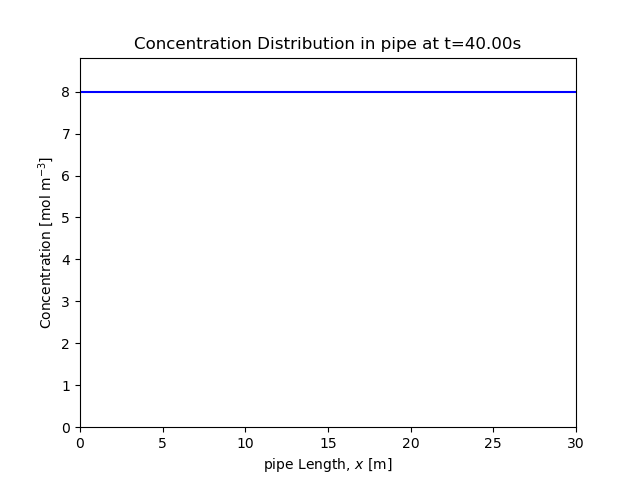

In [10]:
%matplotlib widget

# set up the figure and axes with initial frame
figure, axes = plt.subplots()
line, = axes.plot(lengthArray, concentrationDistributions[:, 0], color='b')
axes.set_xlim(pipeStart, pipeEnd)
axes.set_ylim(np.min(concentrationDistributions), 1.1*np.max(concentrationDistributions))
axes.set_xlabel('pipe Length, $x$ [m]')
axes.set_ylabel('Concentration [mol m$^{-3}$]')
axes.set_title(r'Concentration Distribution in pipe at t=0')

# initialization function: plot the background of each frame
def init():
    line.set_ydata(np.ma.array(lengthArray, mask=True))
    return line,

# update function: this is called for each frame to update the plot
def update(frame):
    line.set_ydata(concentrationDistributions[:, frame])
    axes.set_title(f'Concentration Distribution in pipe at t={timesArray[frame]:.2f}s')
    return line,

# create the animation
animation = FuncAnimation(figure, update, frames=len(timesArray),
                          init_func=init, blit=True, repeat=False)


# save the animation
animation.save('images/distributionOverTime.gif')

### Saturation time

This is the time taken for the pipe to have the same concentration as the feed throughout (i.e., steady state).

We can determine this using our numerical solution of course, but we can derive the analytical solution easily:
$$
t_\mathrm{sat}=\frac{L}{\nu}
$$

which we can also compute

In [8]:
# analytical solution
saturationTime = (pipeEnd - pipeStart) / velocity

# we can use this to generate a concentration profile for the pipe end
# same timespan used as the numerical solution
analyticalTimes = np.array([0,
                            saturationTime-1e-10, saturationTime, # step change
                            timeSpan[1]])
analyticalConcentrationProfile = np.array([initialConcentration,
                                           initialConcentration,
                                           feedConcentration,
                                           feedConcentration])

We can visualise the saturation time by plotting the concentration at the end of the column against the time.
We'll do this for both solutions, numerical and analytical, to compare

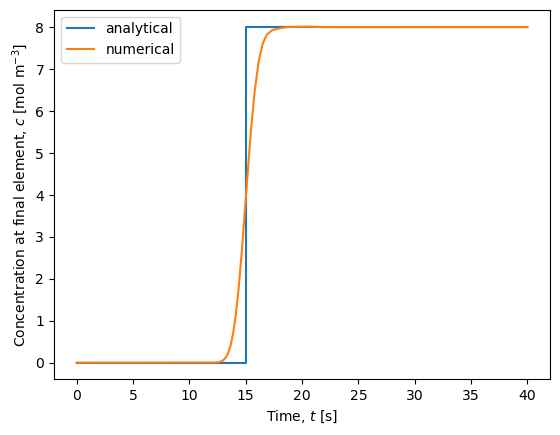

In [12]:
%matplotlib inline

# set up the figure
plt.figure()
plt.xlabel('Time, $t$ [s]')
plt.ylabel('Concentration at final element, $c$ [mol m$^{-3}$]')

# plot solutions
plt.plot(analyticalTimes, analyticalConcentrationProfile, label='analytical')
plt.plot(timesArray, concentrationDistributions[-1,:], label='numerical')

plt.legend()

plt.show()

We notice that the numerical solution is smooth, even though the analytical one is sharp. Why do you think that is? Feel free to download the notebook and experiment.